In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [8]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


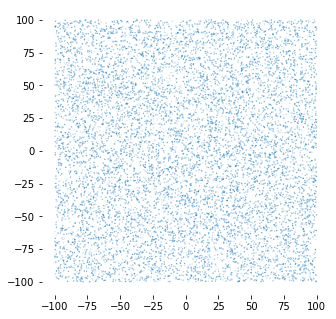

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
scat = ax.scatter(var.iloc[:,1], var.iloc[:,2],s=0.001*var.iloc[:,3])

In [69]:
def preprocessing(M, coordinates, diff):
    

In [108]:
def NaiveApproach(M, distance_max, init_coord):
    distance = 0.
    
    Values = M[:,1:]
    Ids = M[:, 0].astype(int)
    
    actual_coord = init_coord
    ids = []
    rewards = []
    time_temp_1 = time.time()
    while distance < distance_max:
        # Seeking
        mat = np.zeros((Values.shape[0],))
        for row in range(Values.shape[0]):
            mat[row] = math.sqrt((actual_coord[0]- Values[row,0])**2 + (actual_coord[1] - Values[row,1])**2)
            if np.isclose([mat[row]], [0.]):
                mat[row] == 1.
        matrice_ratio =  np.array([(Values[i, 2] / mat[i]) if mat[i] != 0. else 0. for i in range(mat.shape[0])])
        # max position
        target_pos = np.argmax(matrice_ratio)
        if (distance_max-distance) - mat[target_pos] < 0:
            # on peut chercher si il existe une distance < 0 maximum
            break
        else:
            actual_coord, dist, reward = target_pos, mat[target_pos], Values[target_pos, 2]
        
        # end
        distance += dist
        ids.append(Ids[actual_coord])
        rewards.append(reward)
        Values[actual_coord, 2] = 0.
        actual_coord = (Values[actual_coord, 0], Values[actual_coord, 1])
    time_temp_2 = time.time()
    total = round(time_temp_2 - time_temp_1,0)
    total_m = int(total//60)
    total_s = int(total - total_m*60)
    print("Distance:\n   > {}\nTotal Time:\n   > {}m{}s\nTotal Reward:\n   > {}".format(distance, total_m, total_s, sum(rewards)))
    return ids, sum(rewards)

In [110]:
ids, score = NaiveApproach(df.values, 10_000, (0,0))

Distance:
   > 9999.548510817716
Total Time:
   > 0m10s
Total Reward:
   > 2254.0
